In [109]:
import numpy as np
from IPython.display import clear_output
import time
import random
import pandas as pd 
import gurobi

# https://www.youtube.com/watch?v=UXW2yZndl7U

## Code for 6x7x2

In [110]:
def update_board(board_temp, color, column):
    # this is a function that takes the current board status, a color, and a column and outputs the new board status
    # columns 0 - 6 are for putting a checker on the board: if column is full just return the current board...this should be forbidden by the player

    # the color input should be either 'plus' or 'minus'

    board = board_temp.copy()
    ncol = board.shape[1]
    nrow = board.shape[0]

    colsum = board[:, column, 0].sum() + board[:, column, 1].sum()
    row = int(5 - colsum)
    if row > -0.5:
        # if color == "plus":
        #     board[row, column] = 1
        # else:
        #     board[row, column] = 1
        if color == "plus":
            board[row, column, 0] = 1  # Set 'plus' layer
            board[row, column, 1] = 0  # Clear 'minus' layer
        elif color == "minus":
            board[row, column, 1] = 1  # Set 'minus' layer
            board[row, column, 0] = 0  # Clear 'plus' layer
    else:
        print(f"Column {column} is full. No changes made.")

    return board


# in this code the board is a 6x7 numpy array.  Each entry is +1, -1 or 0.  You WILL be able to do a better
# job training your neural network if you rearrange this to be a 6x7x2 numpy array.  If the i'th row and j'th
# column is +1, this can be represented by board[i,j,0]=1.  If it is -1, this can be represented by
# board[i,j,1]=1. It's up to you how you represent your board.

In [111]:
board = np.zeros((6, 7, 2))  # changed for new representation
board = update_board(board, "plus", 3)
board = update_board(board, "minus", 3)
board = update_board(board, "plus", 3)
board = update_board(board, "minus", 3)
board = update_board(board, "plus", 3)
board = update_board(board, "minus", 3)

# Print the board layers
print("Board after filling column 3:")
print("Plus Layer:\n", board[:, :, 0])
print("Minus Layer:\n", board[:, :, 1])

# Trying to add to the full column
board = update_board(board, "plus", 3)

Board after filling column 3:
Plus Layer:
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Minus Layer:
 [[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Column 3 is full. No changes made.


In [112]:
def check_for_win(board, col):
    """
    Check if the last move resulted in a win on a 6x7x2 board.

    Parameters:
        board: np.array (6x7x2)
            The current board state.
        col: int
            The column where the last move was made.

    Returns:
        str: The type of win ('v-plus', 'h-plus', 'd-plus', etc.) or 'nobody'.
    """
    nrow, ncol, _ = board.shape

    # Find the row of the last move
    colsum = board[:, col, 0].sum() + board[:, col, 1].sum()
    row = int(nrow - colsum)

    for layer, player in zip([0, 1], ["plus", "minus"]):
        # Check vertical win
        if row + 3 < nrow:
            if all(board[row + i, col, layer] == 1 for i in range(4)):
                return f"v-{player}"

        # Check horizontal win
        for c_start in range(max(0, col - 3), min(col + 1, ncol - 3)):
            if all(board[row, c_start + i, layer] == 1 for i in range(4)):
                return f"h-{player}"

        # Check diagonal win (bottom-left to top-right)
        for i in range(-3, 1):
            if all(
                0 <= row + i + j < nrow
                and 0 <= col + i + j < ncol
                and board[row + i + j, col + i + j, layer] == 1
                for j in range(4)
            ):
                return f"d-{player}"

        # Check diagonal win (top-left to bottom-right)
        for i in range(-3, 1):
            if all(
                0 <= row - i - j < nrow
                and 0 <= col + i + j < ncol
                and board[row - i - j, col + i + j, layer] == 1
                for j in range(4)
            ):
                return f"d-{player}"

    return "nobody"

In [113]:
def find_legal(board):
    """
    Find all legal moves (columns) on a 6x7x2 board.

    Parameters:
        board: np.array (6x7x2)
            The current board state.

    Returns:
        list: A list of integers representing legal columns.
    """
    legal = [
        i for i in range(board.shape[1]) if board[0, i, 0] == 0 and board[0, i, 1] == 0
    ]
    return legal

In [114]:
def look_for_win(board_, color):
    """
    Check if the current player has a winning move.

    Parameters:
        board_: np.array (6x7x2)
            The current board state.
        color: str ('plus' or 'minus')
            The player's color to check for a winning move.

    Returns:
        int: The column index of a winning move, or -1 if no such move exists.
    """
    board_ = board_.copy()
    legal = find_legal(board_)
    winner = -1

    for m in legal:
        # Simulate the move
        bt = update_board(board_.copy(), color, m)

        # Check if the move results in a win
        wi = check_for_win(bt, m)
        if wi[2:] == color:
            winner = m
            break

    return winner

In [115]:
def find_all_nonlosers(board, color):
    """
    Find all moves that do not immediately lead to a loss for the current player.

    Parameters:
        board: np.array (6x7x2)
            The current board state.
        color: str ('plus' or 'minus')
            The player's color.

    Returns:
        list: A list of column indices representing non-losing moves.
    """
    # Determine opponent's color
    opp = "minus" if color == "plus" else "plus"

    # Get all legal moves
    legal = find_legal(board)

    # Simulate each legal move for the current player
    poss_boards = [update_board(board, color, l) for l in legal]

    # Simulate opponent's response for each resulting board
    poss_legal = [find_legal(b) for b in poss_boards]
    allowed = []

    for i in range(len(legal)):
        # Check if any of the opponent's moves result in a win
        opponent_wins = [
            j
            for j in poss_legal[i]
            if check_for_win(update_board(poss_boards[i], opp, j), j) != "nobody"
        ]

        # If no winning move for the opponent, this move is allowed
        if len(opponent_wins) == 0:
            allowed.append(legal[i])

    return allowed

In [116]:
def back_prop(winner, path, color0, md):
    """
    Perform backpropagation in the MCTS process.

    Parameters:
        winner: str
            The winner of the rollout ('v-plus', 'h-minus', etc., or 'nobody').
        path: list
            A list of board states (flattened tuples) visited during the simulation.
        color0: str ('plus' or 'minus')
            The color of the player initiating the simulation.
        md: dict
            The MCTS dictionary storing visit counts and win scores for each state.
    """
    for i, board_temp in enumerate(path):
        # Increment the visit count for the current board state
        md[board_temp][0] += 1

        # Determine if the current player was the winner
        if winner[2:] == color0:
            # If the winner is the same as the current player
            if i % 2 == 1:
                md[board_temp][1] += 1  # Increment win score
            else:
                md[board_temp][1] -= 1  # Penalize for opponent's win
        elif winner[2:] == "e":  # Handle ties
            # Do nothing for ties, or optionally modify this for tie scoring
            pass
        else:
            # If the opponent was the winner
            if i % 2 == 1:
                md[board_temp][1] -= 1  # Penalize for the player's loss
            else:
                md[board_temp][1] += 1  # Reward for delaying the loss

In [117]:
def rollout(board, next_player):
    """
    Perform a simulation (rollout) from the current board state.

    Parameters:
        board: np.array (6x7x2)
            The current board state.
        next_player: str ('plus' or 'minus')
            The player to start the rollout.

    Returns:
        str: The result of the rollout ('v-plus', 'h-minus', 'tie', or 'nobody').
    """
    winner = "nobody"
    player = next_player

    while winner == "nobody":
        # Find all legal moves
        legal = find_legal(board)
        if len(legal) == 0:
            # No legal moves, it's a tie
            winner = "tie"
            return winner

        # Choose a random legal move
        move = random.choice(legal)

        # Update the board with the chosen move
        board = update_board(board, player, move)

        # Check if this move results in a win
        winner = check_for_win(board, move)

        # Switch player
        player = "minus" if player == "plus" else "plus"

    return winner

In [118]:
def mcts(board_temp, color0, nsteps):
    """
    Perform Monte Carlo Tree Search (MCTS) to determine the best move.

    Parameters:
        board_temp: np.array (6x7x2)
            The current board state.
        color0: str ('plus' or 'minus')
            The player making the move.
        nsteps: int
            The number of iterations for MCTS. Higher values improve accuracy.

    Returns:
        int: The column index of the best move.
    """
    # Make a copy of the board
    board = board_temp.copy()

    ##############################################
    # Immediate win or blocking logic
    winColumn = look_for_win(board, color0)  # Check for a winning column
    if winColumn > -0.5:
        return winColumn  # Play the winning move immediately

    legal0 = find_all_nonlosers(
        board, color0
    )  # Avoid moves that allow the opponent to win
    if len(legal0) == 0:  # If no safe moves, play any legal move
        legal0 = find_legal(board)
    ##############################################

    # Initialize MCTS dictionary to store visit counts and scores
    mcts_dict = {tuple(board.ravel()): [0, 0]}

    # Run MCTS iterations
    for _ in range(nsteps):
        color = color0
        winner = "nobody"
        board_mcts = board.copy()
        path = [tuple(board_mcts.ravel())]  # Track the path of states

        while winner == "nobody":
            legal = find_legal(board_mcts)
            if len(legal) == 0:  # If no legal moves, it's a tie
                winner = "tie"
                back_prop(winner, path, color0, mcts_dict)
                break

            # Generate possible boards for legal moves
            board_list = [
                tuple(update_board(board_mcts, color, col).ravel()) for col in legal
            ]
            for bl in board_list:
                if bl not in mcts_dict:
                    mcts_dict[bl] = [0, 0]

            # Compute UCB1 scores for each move
            ucb1 = np.zeros(len(legal))
            for i, state in enumerate(board_list):
                num, score = mcts_dict[state]
                if num == 0:
                    ucb1[i] = 10 * nsteps  # Prioritize unexplored states
                else:
                    ucb1[i] = score / num + 2 * np.sqrt(
                        np.log(mcts_dict[path[-1]][0]) / num
                    )

            # Choose the move with the highest UCB1 score
            chosen = np.argmax(ucb1)
            board_mcts = update_board(board_mcts, color, legal[chosen])
            path.append(tuple(board_mcts.ravel()))
            winner = check_for_win(board_mcts, legal[chosen])

            # Backpropagate if a winner is found
            if winner[2:] == color:
                back_prop(winner, path, color0, mcts_dict)
                break

            # Switch player
            color = "minus" if color == "plus" else "plus"

            # Perform a rollout if the state has not been visited
            if mcts_dict[tuple(board_mcts.ravel())][0] == 0:
                winner = rollout(board_mcts, color)
                back_prop(winner, path, color0, mcts_dict)
                break

    # Evaluate the best move based on the MCTS dictionary
    maxval = -np.inf
    best_col = -1
    for col in legal0:
        board_temp = tuple(update_board(board, color0, col).ravel())
        num, score = mcts_dict[board_temp]
        if num == 0:
            compare = -np.inf
        else:
            compare = score / num
        if compare > maxval:
            maxval = compare
            best_col = col

    return best_col

In [119]:
mcts(np.zeros((6, 7, 2)), "plus", 1500)

2

In [120]:
# Initialize the board as 6x7x2
board = np.zeros((6, 7, 2), dtype=int)

# Initialize the game state
winner = "nobody"
color = "plus"  # "plus" goes first

while winner == "nobody":
    # Determine which MCTS configuration to use based on the current player
    if color == "minus":
        col = mcts(board, color, 300)  # Opponent gets 300 simulations
    else:
        col = mcts(board, color, 1500)  # Current player gets 1500 simulations

    # Update the board with the chosen move
    board = update_board(board, color, col)

    # Check if this move results in a win
    winner = check_for_win(board, col)

    # Print the current state of the board
    print(f"After {color}'s move in column {col}:")
    print("Plus Layer:\n", board[:, :, 0])
    print("Minus Layer:\n", board[:, :, 1])
    print("=========================")

    # Switch player
    color = "minus" if color == "plus" else "plus"

# Print the winner
print(f"The winner is: {winner}")

After plus's move in column 3:
Plus Layer:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
Minus Layer:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
After minus's move in column 1:
Plus Layer:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
Minus Layer:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]]
After plus's move in column 3:
Plus Layer:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
Minus Layer:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]]
After minus's move in column 3:
Plus Layer:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
Minus Layer:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0

In [121]:
def display_board(board):
    """
    Display the 6x7x2 board as ASCII using X for 'plus' and O for 'minus'.

    Parameters:
        board: np.array (6x7x2)
            The current board state.
    """
    clear_output(wait=True)

    horizontal_line = "-" * (7 * 5 + 8)
    blank_line = "|" + " " * 5
    blank_line *= 7
    blank_line += "|"

    print("   0     1     2     3     4     5     6")
    print(horizontal_line)

    for row in range(6):
        print(blank_line)
        this_line = "|"
        for col in range(7):
            if board[row, col, 0] == 1:  # "plus" layer
                this_line += "  X  |"
            elif board[row, col, 1] == 1:  # "minus" layer
                this_line += "  O  |"
            else:
                this_line += "     |"  # Empty cell
        print(this_line)
        print(blank_line)
        print(horizontal_line)

    print("   0     1     2     3     4     5     6")

### Play a game

In [122]:
# Initialize the board (6x7x2)
winner = "nobody"
board = np.zeros((6, 7, 2), dtype=int)

# Display the initial empty board
display_board(board)

# Set the starting player
player = "plus"

# Game loop
while winner == "nobody":
    # Prompt the current player for their move
    move = input(f"Pick a move (0-6) for player {player}: ")
    try:
        move = int(move)
        if move < 0 or move > 6:
            raise ValueError("Move must be between 0 and 6.")

        # Check if the column is full
        if move not in find_legal(board):
            print("Invalid move. That column is full. Try again.")
            continue

        # Update the board
        board = update_board(board, player, move)

        # Display the updated board
        display_board(board)

        # Check for a winner
        winner = check_for_win(board, move)

        # Switch player
        player = "minus" if player == "plus" else "plus"
    except ValueError as e:
        print("Invalid input. Please enter a number between 0 and 6.")

# Display the winner
print(f"The winner is: {winner}")

   0     1     2     3     4     5     6
-------------------------------------------
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
-------------------------------------------
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
-------------------------------------------
|     |     |     |     |     |     |     |
|     |  X  |     |     |     |     |     |
|     |     |     |     |     |     |     |
-------------------------------------------
|     |     |     |     |     |     |     |
|     |  X  |  O  |     |     |     |     |
|     |     |     |     |     |     |     |
-------------------------------------------
|     |     |     |     |     |     |     |
|     |  X  |  O  |     |     |     |     |
|     |     |     |     |     |     |     |
-------------------------------------------
|     |     |     |     |     |    

### Build dataset

##### No randomness built in

In [123]:
# Function to simulate games and generate the dataset
def generate_dataset(num_games, nsteps_per_move):
    """
    Generate a dataset of board states and the best moves determined by MCTS.

    Parameters:
        num_games (int): Number of games to simulate.
        nsteps_per_move (int): Number of iterations for MCTS per move.

    Returns:
        list: A list of (board, move) pairs for training.
    """
    dataset = []

    for game in range(num_games):
        board = np.zeros((6, 7, 2))  # Initialize empty board
        game_over = False
        player = "plus"

        while not game_over:
            # Run MCTS to determine the best move
            legal_moves = find_legal(board)
            if not legal_moves:
                # No legal moves, it's a tie
                break

            best_move = mcts(board, player, nsteps_per_move)

            # Record the current board state and the best move
            dataset.append((board.copy(), best_move))

            # Update the board with the best move
            board = update_board(board, player, best_move)

            # Check for a win or a tie
            result = check_for_win(board, best_move)
            if result != "nobody":
                game_over = True
                break

            # Switch player
            player = "minus" if player == "plus" else "plus"

    return dataset

In [124]:
num_games = 100  # Number of games to simulate
nsteps_per_move = 100  # MCTS iterations per move

dataset = generate_dataset(num_games, nsteps_per_move)

##### some checks

In [131]:
print(f"Total number of entries in the dataset: {len(dataset)}")

Total number of entries in the dataset: 2897


In [132]:
# Print first 5 entries
for i in range(5):
    board, move = dataset[i]
    print(f"Sample {i + 1}:")
    print("Board State (Layer 0 - Player 1):")
    print(board[:, :, 0])
    print("Board State (Layer 1 - Player 2):")
    print(board[:, :, 1])
    print(f"Recommended Move: {move}\n")

Sample 1:
Board State (Layer 0 - Player 1):
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Board State (Layer 1 - Player 2):
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Recommended Move: 5

Sample 2:
Board State (Layer 0 - Player 1):
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
Board State (Layer 1 - Player 2):
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Recommended Move: 3

Sample 3:
Board State (Layer 0 - Player 1):
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
Board State (Layer 1 - Player 2):

In [133]:
for board, move in dataset:
    # Check for overlaps between layers
    overlaps = np.sum(board[:, :, 0] + board[:, :, 1] > 1)
    assert overlaps == 0, "Invalid board state: Overlapping pieces!"

    # Check for valid column sums
    for col in range(board.shape[1]):
        total_pieces = np.sum(board[:, col, 0] + board[:, col, 1])
        assert total_pieces <= 6, f"Column {col} has too many pieces!"
print("All board states are valid.")

All board states are valid.


In [134]:
for board, move in dataset:
    legal_moves = find_legal(board)
    assert move in legal_moves, f"Illegal move recommended: {move}"
print("All recommended moves are valid.")

All recommended moves are valid.


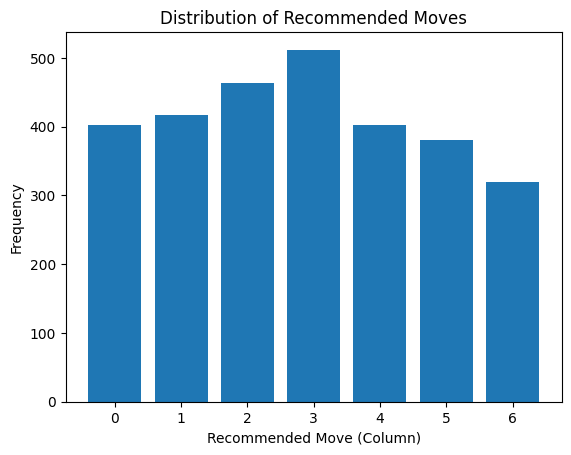

In [135]:
import matplotlib.pyplot as plt
from collections import Counter

move_counts = Counter(move for _, move in dataset)
plt.bar(move_counts.keys(), move_counts.values())
plt.xlabel("Recommended Move (Column)")
plt.ylabel("Frequency")
plt.title("Distribution of Recommended Moves")
plt.show()

##### Some randomness built in

In [136]:
# Function to simulate games and generate the dataset
def generate_dataset_wRand(num_games, nsteps_per_move):
    """
    Generate a dataset of board states and the best moves determined by MCTS, with occasional random moves.

    Parameters:
        num_games (int): Number of games to simulate.
        nsteps_per_move (int): Number of iterations for MCTS per move.

    Returns:
        list: A list of (board, move) pairs for training.
    """
    dataset = []

    for game in range(num_games):
        board = np.zeros((6, 7, 2))  # Initialize empty board
        game_over = False
        player = "plus"

        while not game_over:
            # Occasionally make a random move instead of using MCTS
            if random.random() < 0.1:  # 10% chance to play a random move
                legal_moves = find_legal(board)
                if not legal_moves:
                    break

                random_move = random.choice(legal_moves)
                move = random_move
            else:
                # Run MCTS to determine the best move
                legal_moves = find_legal(board)
                if not legal_moves:
                    break

                move = mcts(board, player, nsteps_per_move)

            # Record the current board state and the move
            dataset.append((board.copy(), move))

            # Update the board with the chosen move
            board = update_board(board, player, move)

            # Check for a win or a tie
            result = check_for_win(board, move)
            if result != "nobody":
                game_over = True
                break

            # Switch player
            player = "minus" if player == "plus" else "plus"

    return dataset

In [140]:
num_games = 500  # Number of games to simulate
nsteps_per_move = 1000  # MCTS iterations per move

dataset_wRand = generate_dataset(num_games, nsteps_per_move)

In [141]:
print(f"Total number of entries in the dataset: {len(dataset_wRand)}")

Total number of entries in the dataset: 16445


In [142]:
# Print first 5 entries
for i in range(5):
    board, move = dataset_wRand[i]
    print(f"Sample {i + 1}:")
    print("Board State (Layer 0 - Player 1):")
    print(board[:, :, 0])
    print("Board State (Layer 1 - Player 2):")
    print(board[:, :, 1])
    print(f"Recommended Move: {move}\n")

Sample 1:
Board State (Layer 0 - Player 1):
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Board State (Layer 1 - Player 2):
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Recommended Move: 3

Sample 2:
Board State (Layer 0 - Player 1):
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Board State (Layer 1 - Player 2):
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Recommended Move: 2

Sample 3:
Board State (Layer 0 - Player 1):
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Board State (Layer 1 - Player 2):

In [143]:
for board, move in dataset_wRand:
    # Check for overlaps between layers
    overlaps = np.sum(board[:, :, 0] + board[:, :, 1] > 1)
    assert overlaps == 0, "Invalid board state: Overlapping pieces!"

    # Check for valid column sums
    for col in range(board.shape[1]):
        total_pieces = np.sum(board[:, col, 0] + board[:, col, 1])
        assert total_pieces <= 6, f"Column {col} has too many pieces!"
print("All board states are valid.")

All board states are valid.


In [144]:
for board, move in dataset_wRand:
    legal_moves = find_legal(board)
    assert move in legal_moves, f"Illegal move recommended: {move}"
print("All recommended moves are valid.")

All recommended moves are valid.


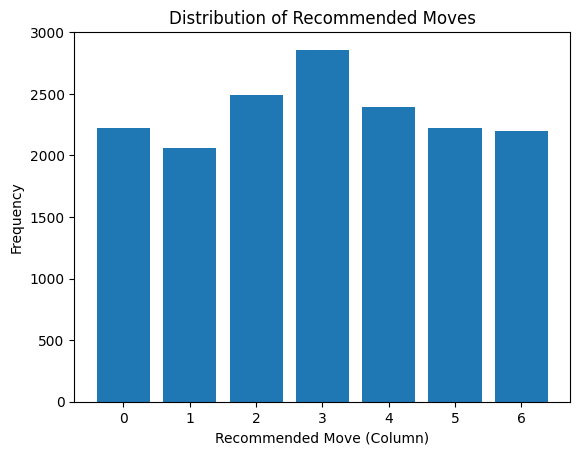

In [145]:
import matplotlib.pyplot as plt
from collections import Counter

move_counts = Counter(move for _, move in dataset_wRand)
plt.bar(move_counts.keys(), move_counts.values())
plt.xlabel("Recommended Move (Column)")
plt.ylabel("Frequency")
plt.title("Distribution of Recommended Moves")
plt.show()

##### Save if want

In [ ]:
# # Save dataset to a file
# def save_dataset(dataset, filename):
#     """
#     Save the dataset to a file.

#     Parameters:
#         dataset (list): List of (board, move) pairs.
#         filename (str): Name of the file to save the dataset.
#     """
#     with open(filename, "wb") as f:
#         import pickle
#         pickle.dump(dataset, f)

# save_dataset(dataset, "connect4_dataset.pkl")
# print(f"Dataset generated with {len(dataset)} entries.")